# **Transformer**

A Pytorch implementation of the basic transformer model.  
  
**Dataset:**  Korean chatbot dataset.  

**Reference:**  
https://wikidocs.net/31379  
https://tunz.kr/post/4

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import pickle
import numpy as np
import re
import random

## Hyper Parameters

In [ ]:
d_model = 256
num_layers = 2
num_heads = 4
d_ff = 512

batch_size = 64
epochs = 50
warmup_step = 4000
dropout = 0.1

isCuda = True
device = torch.device("cuda:0" if (torch.cuda.is_available() and isCuda) else "cpu")
torch.backends.cudnn.benchmark = True
print("Device: {}".format(device))

model_saved_dir = "/content/drive/MyDrive/Colab Notebooks/Transformer"

Device: cuda:0


## Dataset (Korean Chatbot)

In [ ]:
import urllib.request
import pandas as pd

urllib.request.urlretrieve("https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData.csv", filename="ChatBotData.csv")
train_data = pd.read_csv('ChatBotData.csv')
train_data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [ ]:
print(len(train_data))

11823


### Separate punctuation marks

In [ ]:
questions = []
answers = []

for s in train_data['Q']:
  s = re.sub(r"([?.!,])", r" \1 ", s)
  questions.append(s.strip())

for s in train_data['A']:
  s = re.sub(r"([?.!,])", r" \1 ", s)
  answers.append(s.strip())

In [ ]:
print(questions[:5])
print(answers[:5])

['12시 땡 !', '1지망 학교 떨어졌어', '3박4일 놀러가고 싶다', '3박4일 정도 놀러가고 싶다', 'PPL 심하네']
['하루가 또 가네요 .', '위로해 드립니다 .', '여행은 언제나 좋죠 .', '여행은 언제나 좋죠 .', '눈살이 찌푸려지죠 .']


### Tokenizer

In [ ]:
import tensorflow_datasets as tfds
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    questions + answers, target_vocab_size=2**13)

START_TOKEN = [tokenizer.vocab_size]
END_TOKEN = [tokenizer.vocab_size + 1]
vocab_size = tokenizer.vocab_size + 2

In [ ]:
print(vocab_size)

8180


In [ ]:
sample = questions[40]
print('Sample: %s' % sample)

tokenized = tokenizer.encode(sample)
print('Encode: %s\n' % tokenized)

for t in tokenized:
  print('%d ---> %s' % (t, tokenizer.decode([t])))

Sample: 간만에 떨리니까 좋더라
Encode: [7875, 1717, 320, 4884]

7875 ---> 간만에 
1717 ---> 떨리
320 ---> 니까 
4884 ---> 좋더라


Maximum length of tokenized sentence: 29
>> 연애는 문제가 있으면 문제를 해결 하기 위해 함께 노력하고 그 속에서 더욱 단단해지는 과정인데 ,  그 과정을 못 참고 피하기만 했나봅니다 .


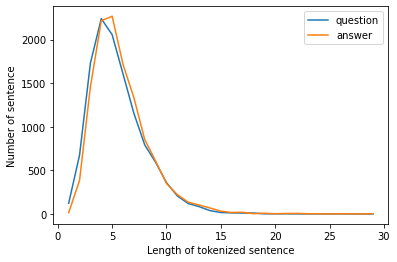

In [ ]:
import matplotlib.pyplot as plt

qlen = [0]*40
alen = [0]*40

maxlen = 0
maxstring = ""
for q in questions:
  t = len(tokenizer.encode(q))
  qlen[t] = qlen[t] + 1
  if maxlen < t:
    maxlen = t
    maxstring = q
for a in answers:
  t = len(tokenizer.encode(a))
  alen[t] = alen[t] + 1
  if maxlen < t:
    maxlen = t
    maxstring = a

print('Maximum length of tokenized sentence: %d' % maxlen)
print('>> %s' % maxstring)

plt.plot(range(1,(maxlen+1)), qlen[1:(maxlen+1)], range(1,(maxlen+1)), alen[1:(maxlen+1)])
plt.legend(['question', 'answer'])
plt.xlabel('Length of tokenized sentence')
plt.ylabel('Number of sentence')
#plt.show()
plt.savefig('dataset-plot.png')

### Custom Dataset

In [ ]:
maxlen = 40

class QADataset(Dataset):
  def __init__(self, tokenizer, questions, answers):
    self.data = []

    for q, a in zip(questions, answers):
      q = START_TOKEN + tokenizer.encode(q) + END_TOKEN
      q = q + [0]*(maxlen-len(q))
      a = tokenizer.encode(a) + END_TOKEN
      a = a + [0]*(maxlen-2-len(a))
      self.data.append((torch.LongTensor(q), 
                        torch.LongTensor(START_TOKEN + a), 
                        torch.LongTensor(a + [0])))

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    return self.data[idx]

In [ ]:
n_v, n_t = 100, 10

# shuffle
temp = list(zip(questions, answers))
random.shuffle(temp)
questions, answers = zip(*temp)

dataset = QADataset(tokenizer, questions[:(-n_v-n_t)], answers[:(-n_v-n_t)])
valid_dataset = QADataset(tokenizer, questions[(-n_v-n_t):(-n_t)], answers[(-n_v-n_t):(-n_t)])
test_dataset = QADataset(tokenizer, questions[(-n_t):], answers[(-n_t):])

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=n_v, shuffle=False)

print(len(dataset))

ei, di, do = dataset[0]
print(ei)
print(di)
print(do)

11713
tensor([8178, 1586, 8179,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0])
tensor([8178, 3477,   92,    1, 8179,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0])
tensor([3477,   92,    1, 8179,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0])


## Model

### Weight and Bias Initailization

In [ ]:
def init_weight(layer):
    nn.init.xavier_uniform_(layer.weight)
    if layer.bias is not None:
        nn.init.constant_(layer.bias, 0)

### Positional Encoding

In [ ]:
class PositionalEncoding(nn.Module):
  def __init__(self, max_len, d_model):
    super(PositionalEncoding, self).__init__()
    self.d_model = d_model
    self.angles = torch.Tensor([(2*(i//2)) / self.d_model for i in range(self.d_model)])
    self.angles = 1 / torch.pow(10000, self.angles)

    self.enc = torch.zeros(max_len+1, d_model).cuda()
    self.enc.requires_grad = False

    for pos in range(max_len+1):
      p = pos * self.angles
      self.enc[pos, 0::2] = torch.sin(p[0::2])
      self.enc[pos, 1::2] = torch.cos(p[1::2])

  def forward(self, x):
    batch, len = x.size()
    pos_embed = self.enc[1:(len+1), :].clone().detach()     # (len, d_model)
    pos_embed = pos_embed.unsqueeze(0).repeat(batch, 1, 1)  # (batch, len, d_model)
    
    pos_mask = (x != 0).unsqueeze(2).repeat(1, 1, self.d_model).cuda()
    pos_embed = pos_embed.masked_fill(pos_mask == 0, 0)

    return pos_embed

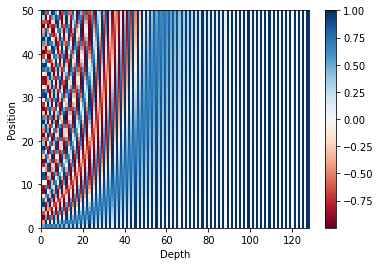

In [ ]:
pe = PositionalEncoding(50, 128)
x = torch.ones([1, 50]).cuda()
y = pe(x).squeeze(0)

plt.pcolormesh(y.cpu().numpy(), cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 128))
plt.ylabel('Position')
plt.colorbar()
plt.show()

### Multi Head Attention

In [ ]:
class MultiHeadAttention(nn.Module):
  def __init__(self, d_model, num_heads, dropout):
    super(MultiHeadAttention, self).__init__()
    self.d_model = d_model
    self.num_heads = num_heads
    self.depth = d_model // num_heads

    self.WQ = nn.Linear(d_model, d_model, bias=False)
    self.WK = nn.Linear(d_model, d_model, bias=False)
    self.WV = nn.Linear(d_model, d_model, bias=False)
    self.WO = nn.Linear(d_model, d_model, bias=False)
    self.softmax = nn.Softmax(dim=-1)
    self.dropout = nn.Dropout(dropout)

    init_weight(self.WQ)
    init_weight(self.WK)
    init_weight(self.WV)
    init_weight(self.WO)


  def scaled_dot_product_attention(self, query, key, value, mask=None):
    # query, key, value: (batch, num_heads, len, depth)
    QK = torch.matmul(query, key.transpose(2, 3)) / (self.depth ** 0.5)
    # QK: (batch, num_heads, query_len, key_len)

    if mask is not None:
      QK = QK.masked_fill(mask == 0, -np.inf)
    
    attention = self.softmax(QK)
    output = torch.matmul(attention, value)
    # output: (batch, num_heads, query_len, depth)

    return output, attention


  def split_heads(self, x, batch):
    x = x.view(batch, -1, self.num_heads, self.depth).transpose(1,2)
    return x


  def forward(self, query, key, value, mask):
    batch = query.size(0)
    # (batch, len, d_model)
    query = self.WQ(query)
    key = self.WK(key)
    value = self.WV(value)
    # (batch, len, d_model)
    query = self.split_heads(query, batch)
    key = self.split_heads(key, batch)
    value = self.split_heads(value, batch)
    # (batch, num_heads, len, depth)

    attention, score = self.scaled_dot_product_attention(query, key, value, mask)
    # attention: (batch, num_heads, query_len, depth)
    # score:     (batch, num_heads, query_len, key_len)
    
    attention = attention.transpose(1,2).contiguous()
    # (batch, query_len, num_heads, depth)
    concat = attention.view(batch, -1, self.d_model)
    # (batch, query_len, d_model)
    output = self.dropout(self.WO(concat))
    # (batch, query_len, d_model)
    return output, score

### Position-wise Feed Forward

In [ ]:
class PositionWiseFeedForward(nn.Module):
  def __init__(self, d_model, d_ff):
    super(PositionWiseFeedForward, self).__init__()
    self.conv1 = nn.Conv1d(d_model, d_ff, kernel_size=1)
    self.conv2 = nn.Conv1d(d_ff, d_model, kernel_size=1)
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(dropout)

    init_weight(self.conv1)
    init_weight(self.conv2)

  def forward(self, x):
    # (batch, len, d_model)
    x = x.permute(0, 2, 1)
    # (batch, d_model, len)
    x = self.dropout(self.relu(self.conv1(x)))
    # (batch, d_ff, len)
    x = self.conv2(x)
    # (batch, d_model, len)
    x = self.dropout(x.permute(0, 2, 1))
    # (batch, len, d_model)
    return x

### Encoder

In [ ]:
class EncoderLayer(nn.Module):
  def __init__(self, d_model, num_heads, d_ff, dropout):
    super(EncoderLayer, self).__init__()
    self.ln1 = nn.LayerNorm(d_model, eps=1e-6)
    self.attention = MultiHeadAttention(d_model, num_heads, dropout)
    self.ln2 = nn.LayerNorm(d_model, eps=1e-6)
    self.ffn = PositionWiseFeedForward(d_model, d_ff)

  def forward(self, x, mask):
    # Multi Head Attention
    # query = key = value (= x)
    norm_x = self.ln1(x)
    x = x + self.attention(norm_x, norm_x, norm_x, mask)[0]
    
    # Position-wise Feed Forward Network
    norm_x = self.ln2(x)
    x = x + self.ffn(norm_x)

    return x

In [ ]:
class Encoder(nn.Module):
  def __init__(self, vocab_size, d_model, num_layers, num_heads, d_ff, dropout):
    super(Encoder, self).__init__()
    self.d_model = d_model
    self.num_heads = num_heads

    self.embed = nn.Embedding(num_embeddings = vocab_size,
                               embedding_dim = d_model,
                               padding_idx = 0)
    nn.init.normal_(self.embed.weight, mean=0, std=(d_model**-0.5))
    self.position = PositionalEncoding(vocab_size, d_model)
    self.dropout = nn.Dropout(p=dropout)

    self.blocks = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])

  
  def forward(self, x, mask):
    pos = self.position(x)
    x = self.embed(x) * (self.d_model ** 0.5)
    x = self.dropout(x + pos)

    for block in self.blocks:
      x = block(x, mask)

    return x

### Decoder

In [ ]:
class DecoderLayer(nn.Module):
  def __init__(self, d_model, num_heads, d_ff, dropout):
    super(DecoderLayer, self).__init__()
    self.ln1 = nn.LayerNorm(d_model, eps=1e-6)
    self.attention1 = MultiHeadAttention(d_model, num_heads, dropout)

    self.ln2 = nn.LayerNorm(d_model, eps=1e-6)
    self.attention2 = MultiHeadAttention(d_model, num_heads, dropout)

    self.ffn = PositionWiseFeedForward(d_model, d_ff)
    self.ln3 = nn.LayerNorm(d_model, eps=1e-6)


  def forward(self, x, enc, look_ahead_mask, padding_mask):
    # Masked Self Attention (query = key = value = norm_x))
    norm_x = self.ln1(x)
    x = x + self.attention1(norm_x, norm_x, norm_x, look_ahead_mask)[0]

    # Decoder-Encoder Attention (query = norm_x, key = value = enc)
    norm_x = self.ln2(x)
    attn, attn_map = self.attention2(norm_x, enc, enc, padding_mask)
    x = x + attn
    
    # Position-wise Feed Forward Network
    norm_x = self.ln3(x)
    x = x + self.ffn(norm_x)

    return x, attn_map

In [46]:
class Decoder(nn.Module):
  def __init__(self, vocab_size, d_model, num_layers, num_heads, d_ff, dropout):
    super(Decoder, self).__init__()
    self.d_model = d_model
    self.num_heads = num_heads

    self.embed = nn.Embedding(num_embeddings = vocab_size,
                               embedding_dim = d_model,
                               padding_idx = 0)
    nn.init.normal_(self.embed.weight, mean=0, std=(d_model**-0.5))
    self.position = PositionalEncoding(vocab_size, d_model)
    self.dropout = nn.Dropout(p=dropout)

    self.blocks = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
    self.ln = nn.LayerNorm(d_model, eps=1e-6)
    #self.fc = nn.Linear(d_model, vocab_size)

  def forward(self, x, enc_out, look_ahead_mask, padding_mask):
    pos = self.position(x)
    x = self.embed(x) * (self.d_model ** 0.5)
    x = self.dropout(x + pos)

    for block in self.blocks:
      x, attn_map = block(x, enc_out, look_ahead_mask, padding_mask)

    x = self.ln(x)
    x = torch.matmul(x, self.embed.weight.transpose(0, 1))
    #x = self.fc(x)

    return x, attn_map

### Transformer

In [47]:
class Transformer(nn.Module):
  def __init__(self, enc_vocab_size, dec_vocab_size, d_model, num_layers, num_heads, d_ff, dropout):
    super(Transformer, self).__init__()
    self.enc = Encoder(enc_vocab_size, d_model, num_layers, num_heads, d_ff, dropout)
    self.dec = Decoder(dec_vocab_size, d_model, num_layers, num_heads, d_ff, dropout)

  def forward(self, enc_input, dec_input, padding_mask, look_ahead_mask):
    enc_output = self.enc(enc_input, padding_mask)
    dec_output, attn_map = self.dec(dec_input, enc_output, look_ahead_mask, padding_mask)
    return dec_output, attn_map

## Training

In [48]:
transformer = Transformer(vocab_size, vocab_size, d_model, num_layers, num_heads, d_ff, dropout).cuda()

### (Option) Load Model

In [50]:
model_name = 'Transformer_2layers'

loss_path = F"{model_saved_dir}/{model_name}_loss.txt"
model_path = F"{model_saved_dir}/{model_name}.pt"

with open(loss_path, 'rb') as f:
    losses, val_losses = pickle.load(f)

transformer.load_state_dict(torch.load(model_path))

<All keys matched successfully>

### Optimizer and Learning Rate

In [51]:
class ScheduledAdam():
    def __init__(self, optimizer, d_model, warm_steps):
        self.init_lr = np.power(d_model, -0.5)
        self.optimizer = optimizer
        self.current_steps = 0
        self.warm_steps = warm_steps

    def step(self):
        self.current_steps += 1
        lr = self.init_lr * self.get_scale()
        
        for p in self.optimizer.param_groups:
            p['lr'] = lr

        self.optimizer.step()
        
    def zero_grad(self):
        self.optimizer.zero_grad()

    def get_scale(self):
        return np.min([
            np.power(self.current_steps, -0.5),
            self.current_steps * np.power(self.warm_steps, -1.5)
        ])


optimizer = ScheduledAdam(
            torch.optim.Adam(transformer.parameters(), betas=(0.9, 0.98), eps=1e-9),
            d_model=d_model,
            warm_steps=warmup_step
        )

### Loss Function

In [ ]:
criterion = nn.CrossEntropyLoss(ignore_index = 0)

### Training Model

In [ ]:
model_name = 'Transformer_2layers_fc'

loss_path = F"{model_saved_dir}/{model_name}_loss.txt"
model_path = F"{model_saved_dir}/{model_name}.pt"

start_epoch = 0

if start_epoch == 0:
  losses, val_losses = [], []


def forward(enc_input, dec_input, dec_output):
  # Padding Mask
  padding_mask = (enc_input != 0).unsqueeze(1).unsqueeze(2).cuda()

  # Look Ahead Mask
  mask1 = (dec_input != 0).unsqueeze(1).unsqueeze(2).cuda()
  mask2 = torch.tril(torch.ones((dec_input.size(1), dec_input.size(1)), device = device)).bool()
  look_ahead_mask = mask1 & mask2

  enc_input = enc_input.cuda()
  dec_input = dec_input.cuda()
  dec_output = dec_output.cuda()

  out, _ = transformer(enc_input, dec_input, padding_mask, look_ahead_mask)

  out = out.contiguous().view(-1, out.shape[-1])
  dec_output = dec_output.contiguous().view(-1)
  loss = criterion(out, dec_output)
  
  return loss


for ep in range(start_epoch, epochs):
  for batch_idx, (enc_input, dec_input, dec_output) in enumerate(dataloader, 0):
    # Train
    transformer.train()
    optimizer.zero_grad()
    loss = forward(enc_input, dec_input, dec_output)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(transformer.parameters(), 1.0)
    optimizer.step()

    # Evaluate
    transformer.eval()
    with torch.no_grad():
      enc_input, dec_input, dec_output = next(iter(valid_dataloader))
      val_loss = forward(enc_input, dec_input, dec_output)

    # Print losses and learning rate
    if batch_idx % 50 == 49 or batch_idx == (len(dataloader)-1):
      lr = optimizer.optimizer.param_groups[0]['lr']
      print('[%2d/%2d][%3d/%3d]\tLoss: %.4f/%.4f\tLR: %.6f' \
            % (ep+1, epochs, batch_idx+1, len(dataloader), loss.item(), val_loss.item(), lr))
    
    losses.append(loss.item())
    val_losses.append(val_loss.item())

  torch.save(transformer.state_dict(), model_path)
  with open(loss_path, 'wb') as f:
      pickle.dump((losses, val_losses), f)
  
  print("Saved model completely!")

### Plot step vs. loss

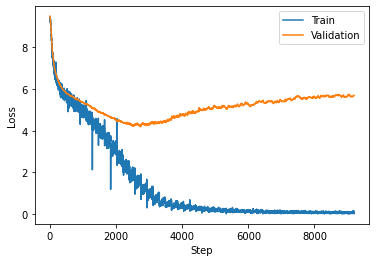

In [82]:
plt.plot(range(len(losses)), losses, range(len(val_losses)), val_losses)
plt.legend(['Train', 'Validation'])
plt.xlabel('Step')
plt.ylabel('Loss')
#plt.show()
plt.savefig('loss-2layers.png')

## Predict sentences

In [ ]:
def predict(s):
  transformer.eval()
  s = re.sub(r"([?.!,])", r" \1 ", s).strip()

  s = START_TOKEN + tokenizer.encode(s) + END_TOKEN
  s = torch.LongTensor(s).unsqueeze(0).cuda()

  d_in = torch.LongTensor(START_TOKEN).unsqueeze(0).cuda()

  # Padding Mask
  padding_mask = (s != 0).unsqueeze(1).unsqueeze(2).cuda()

  for i in range(maxlen-1):
    # Look Ahead Mask
    mask1 = (d_in != 0).unsqueeze(1).unsqueeze(2).cuda()
    mask2 = torch.tril(torch.ones((d_in.size(1), d_in.size(1)), device = device)).bool()
    look_ahead_mask = mask1 & mask2

    out, attn_map = transformer(s, d_in, padding_mask, look_ahead_mask)
    d_out = torch.argmax(out, dim=-1)
    last = d_out[:, -1:]

    if last[0][0] == END_TOKEN[0]:
      break

    d_in = torch.cat([d_in, last], dim=1)

  output = d_in.squeeze(0)

  s = tokenizer.decode([i for i in output if i < tokenizer.vocab_size])
  for mark in '?.!,':
    s = s.replace(' '+mark, mark)

  return s, attn_map.squeeze(0)

### sentences in the dataset

In [83]:
for i in range(10):
  q = questions[i]
  print('Input: %s' % q)
  print('Output: %s' % predict(q)[0])
  a = answers[i]
  for mark in '?.!,':
    a = a.replace(' '+mark, mark)
  print('Answer: %s\n' % a)

Input: 고백
Output: 성공하길 바랄게요.
Answer: 성공하길 바랄게요.

Input: 너무 편해도 안 좋아
Output: 예의는 지켜주세요.
Answer: 예의는 지켜주세요.

Input: 사랑은 상처를
Output: 남기고 가요.
Answer: 남기고 가요.

Input: 꿈에서 전남친 친구가나왓는데
Output: 무슨 일이 있었나봐요.
Answer: 무슨 일이 있었나봐요.

Input: 나 윗집 남자애 좋아하는 것 같애 .
Output: 가깝게 살아서 더 좋겠네요.
Answer: 가깝게 살아서 더 좋겠네요.

Input: 제 마음과 머리가 일치가 안되 .
Output: 마음이랑 머리가 따로 놀기도 하죠.
Answer: 마음이랑 머리가 따로 놀기도 하죠.

Input: 심부름 다녀올게
Output: 다녀오세요.  기다릴게요.
Answer: 다녀오세요.  기다릴게요.

Input: 사랑할수록 집착해
Output: 상대방이 싫어할수도 있어요.
Answer: 상대방이 싫어할수도 있어요.

Input: 정신줄 어디 갔나
Output: 정신 차리세요.
Answer: 정신 차리세요.

Input: 이젠 다시 만날 수도 없는 상황
Output: 달라지는게 없다면 이런 상황이 더 나을지도 몰라요.
Answer: 달라지는게 없다면 이런 상황이 더 나을지도 몰라요.



### sentences not in the dataset

In [85]:
sentences = ["영화 볼래?", "고민이 있어", "너무 화가나", "카페갈래?", "게임하고싶당", "게임하자!"]

for s in sentences:
  print('Input: %s' % s)
  print('Output: %s\n' % predict(s)[0])

Input: 영화 볼래?
Output: 최신 영화가 좋을 것 같아요.

Input: 고민이 있어
Output: 생각을 할 수 있어요.

Input: 너무 화가나
Output: 제가 풀어드릴게요.

Input: 카페갈래?
Output: 카페 데이트 좋죠.

Input: 게임하고싶당
Output: 생각보다 빠르게 시군요.

Input: 게임하자!
Output: 게임하세요!



In [84]:
sentences = ["같이 1박2일 여행 갈까?",
             "내일 우리 같이 영화나 볼까?",
             "오늘 점심은 뭘 먹어야 할지 모르겠네",
             "하루종일 머리가 아프네",
             "내일 시험인데 하나도 공부를 못 했어"]

for s in sentences:
  print('Input: %s' % s)
  print('Output: %s\n' % predict(s)[0])

Input: 같이 1박2일 여행 갈까?
Output: 같이 양이 있어서 그런가봐요.

Input: 내일 우리 같이 영화나 볼까?
Output: 원하던게 아니었을지도 몰라요.

Input: 오늘 점심은 뭘 먹어야 할지 모르겠네
Output: 해보는 것도 좋을 거 같아요.

Input: 하루종일 머리가 아프네
Output: 병원에 가보세요.

Input: 내일 시험인데 하나도 공부를 못 했어
Output: 컨디션 조절 하세요.



## BLEU Score

In [74]:
from collections import Counter

def bleu(pred, real):
  pred = [int(i) for i in pred if i < tokenizer.vocab_size and i > 0]
  real = [int(i) for i in real if i < tokenizer.vocab_size and i > 0]

  n_tot = min(len(pred), 4)
  if n_tot == 0: return 0

  score = 1.
  for n in range(1, n_tot+1):
    pCounter = Counter([tuple(pred[i:(i+n)]) for i in range(len(pred)-n+1)])
    rCounter = Counter([tuple(real[i:(i+n)]) for i in range(len(real)-n+1)])

    cnt = 0
    for word in pCounter:
      if word in rCounter:
        cnt += min(pCounter[word], rCounter[word])

    score *= cnt / max(len(pred)-n+1, 1)
  
  return (score ** (1/n_tot)) * min(1., len(pred)/len(real))

In [80]:
transformer.eval()
with torch.no_grad():
  enc_input, dec_input, dec_output = next(iter(dataloader))

  # Padding Mask
  padding_mask = (enc_input != 0).unsqueeze(1).unsqueeze(2).cuda()

  # Look Ahead Mask
  mask1 = (dec_input != 0).unsqueeze(1).unsqueeze(2).cuda()
  mask2 = torch.tril(torch.ones((dec_input.size(1), dec_input.size(1)), device = device)).bool()
  look_ahead_mask = mask1 & mask2

  enc_input = enc_input.cuda()
  dec_input = dec_input.cuda()
  dec_output = dec_output.cuda()

  out, _ = transformer(enc_input, dec_input, padding_mask, look_ahead_mask)
  pred = torch.argmax(out, dim=-1)
  
  scores = sum([bleu(p,r) for p, r in zip(pred, dec_output)]) / pred.size(0)
  print('BLEU Score for training data: %.4f' % (100*scores))

BLEU Score for training data: 88.4512


## Attention Map

시간을 정하고 해보세요.


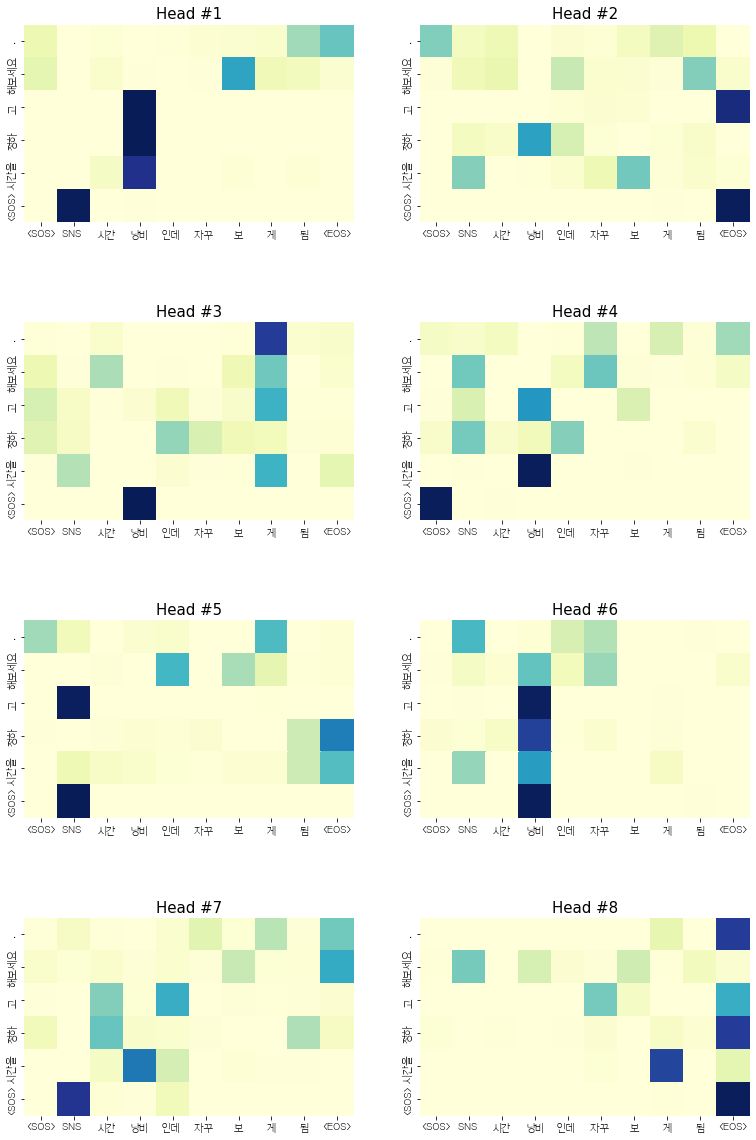

In [86]:
import seaborn as sns
import matplotlib.font_manager as fm

q = "SNS 시간낭비인데 자꾸 보게됨"
a, attn_map = predict(q)
print(a)
attn_map = attn_map.cpu().detach().numpy()
attn_map = np.flip(attn_map, axis=1)
q_str = ['<SOS>'] + [tokenizer.decode([t]) for t in tokenizer.encode(q)] + ['<EOS>']
a_str = list(reversed(['<SOS>']+[tokenizer.decode([t]) for t in tokenizer.encode(a)]))

font_location = "/content/drive/MyDrive/Colab Notebooks/Transformer/DreamGothic.otf"
fp = fm.FontProperties(fname=font_location)
f, axes = plt.subplots(4, 2, figsize=(13, 21))

for k in range(8):
  row, col = k // 2, k % 2
  g = sns.heatmap(attn_map[k],
                  vmin = 0.0,
                  vmax = 1.0,
                  cmap = 'YlGnBu',
                  cbar = False,
                  ax = axes[row, col],
                  square = True)
  axes[row,col].set_title('Head #{}'.format(k+1), fontsize=15)
  axes[row,col].set_xticklabels(q_str, fontproperties = fp)
  axes[row,col].set_yticklabels(a_str, fontproperties = fp)

#plt.show()
plt.savefig('attention-map.png')